In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from keras.callbacks import ModelCheckpoint
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras import regularizers

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)

Using TensorFlow backend.


In [3]:
ONE_DAY_LAGS = 288
DATA_PATH = '/mnt/sdc1/inon/norrecampus/data/by_place_5min'
EXAMPLE_PLACE_ID = 'ChIJZaR1M1hSUkYRxP0WkwYYy_k'

THRESHOLD_HIGH_OUTLIER = 110
LOSS = 'mse'
MINI_BATCH_SIZE = 512
NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2
NUM_LAGS = 12
LSTM_STATE_SIZE = NUM_LAGS
NUM_OUTS_MEAN_SPEED_REGRESSION = 1
SPLIT_DATE = '2015-06-01'

In [4]:
def split_timestamp(ser):
    return pd\
        .DataFrame(ser)\
        .assign(day_of_week=lambda df: df.index.dayofweek, time_of_day=lambda df: df.index.time)\
        .reset_index()

In [5]:
def compute_error_statistics_and_plot_15jan2017(errors_df):
    errors_df.drop('error', axis=1)[ONE_DAY_LAGS * 15:ONE_DAY_LAGS * 16].plot()
    plt.legend()
    
    abs_errors = errors_df.error.abs()
    abs_errors_normalized = abs_errors / errors_df.flow_decile_true
    return {
        'corr': np.corrcoef(errors_df.flow_decile_predicted, errors_df.flow_decile_true)[0, 1],
        'mae': np.mean(abs_errors),
        'mape': np.mean(abs_errors_normalized),
        'mse': np.mean(abs_errors ** 2),
        'msne': np.mean(abs_errors_normalized ** 2),
        'rae': np.sum(abs_errors) / np.sum(np.abs(errors_df.flow_decile_true - np.mean(errors_df.flow_decile_true))),
        'rmse': np.sqrt(np.mean(abs_errors ** 2)),
        'rmsne': np.sqrt(np.mean(abs_errors_normalized ** 2)),
        'r2': max(0, 1 - np.sum(abs_errors ** 2) / np.sum((errors_df.flow_decile_true - np.mean(errors_df.flow_decile_true)) ** 2))
    }

In [6]:
class LearnerForFlowDecileOfOneSegmentWithoutDetrending(object):
    def __init__(self,
                 loss,
                 place_id, 
                 mini_batch_size,
                 num_epochs,
                 validation_split,
                 num_lags,
                 lstm_state_size,
                 num_outs,
                 split_date):
        self.df = None
        self.model = None
        
        self.loss = loss
        self.place_id = place_id
        self.mini_batch_size = mini_batch_size
        self.num_epochs = num_epochs
        self.validation_split = validation_split
        self.num_lags = num_lags
        self.lstm_state_size = lstm_state_size
        self.num_outs = num_outs
        self.split_date = split_date
        self.checkpoint_basename = 'simple_lstm_flow_%s.best.hdf5' % self.place_id      
    
    def baseline_lr(self):
        X_train, Y_train, X_test, Y_test = learner._get_train_and_test_inputs()
        trained_lr = LinearRegression(fit_intercept=False).fit(X_train.values, Y_train.values)
        lr_predictions = trained_lr.predict(X_test).round(0)
        errors_df = self._individual_errors_without_interpolated_values(lr_predictions)
        return compute_error_statistics_and_plot_15jan2017(errors_df)
                    
    def _imputation_for_missing_values(self, ser):
        missing_timestamps = pd\
            .date_range(min(ser.index.date), max(ser.index.date) + timedelta(days=1), freq='5T')\
            .difference(ser.index)
        df_with_nans_where_missing = pd.DataFrame(ser)\
            .join(pd.DataFrame(index=missing_timestamps), how='outer')\
            .assign(original_value=lambda df: df.iloc[:, 0])
        df_interpolated = df_with_nans_where_missing\
            .iloc[:, 0]\
            .interpolate()\
            .round()\
            .astype(np.int64)\
            .to_frame()\
            .assign(original_value=df_with_nans_where_missing.original_value)\
            .assign(is_interpolated=lambda df: df.iloc[:, 0] != df.iloc[:, 1])
        assert all(df_interpolated.flow_decile.isin(range(10)))
        return df_interpolated
        
    def _get_flows(self):
        if self.df is None:
            self.df = pd.read_csv(
                os.path.join(DATA_PATH, self.place_id + '.csv'),
                parse_dates=['start_interval_s', 'end_interval_s']\
            )[lambda df: df.start_interval_s >= '2015-01-01']\
            .rename(columns={'start_interval_s': 't', 'flow_bucket': 'flow_decile'})\
            .set_index('t')\
            .flow_decile
        return self.df

    def _get_train_and_test_inputs(self):
        flows_interpolated = self._imputation_for_missing_values(self._get_flows()).flow_decile
        lags = pd.concat([flows_interpolated.shift(x) for x in range(self.num_lags + 1)], axis=1)[self.num_lags:]
        train = lags[lags.index < self.split_date]
        X_train = train.iloc[:, 1:]
        Y_train = train.iloc[:, 0]
        test = lags[lags.index >= self.split_date]
        X_test = test.iloc[:, 1:]
        Y_test = test.iloc[:, 0]
        return X_train, Y_train, X_test, Y_test

    def _build_model(self):
        # TODO: better weights initialization
        self.model = Sequential()
        self.model.add(LSTM(self.lstm_state_size, input_shape=(self.num_lags, 1), return_sequences=False))
        # model.add(Dropout(0.2))
        #model.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.00001)))
        self.model.add(Dense(units=self.num_outs, activation="linear")) # TODO: also try relu, as ordinal categories are non-negative
        self.model.compile(loss=self.loss, optimizer="rmsprop")  # TODO: try adam optimizer too, although rmsprop is the default go-to for RNN
    
    def load_best_model_from_disk(self):
        self._build_model()
        self.model.load_weights(self.checkpoint_basename)
    
    def create_and_train_model(self):
        self._build_model()
        X_train, Y_train, _, _ = self._get_train_and_test_inputs()
        self.model.fit(
            np.expand_dims(np.array(X_train.values), 2),
            Y_train.values,
            batch_size=self.mini_batch_size,
            epochs=self.num_epochs,
            validation_split=self.validation_split,
            # checkpoint best model
            callbacks=[ModelCheckpoint(
                self.checkpoint_basename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')],
            verbose=2)
        self.model.load_weights(self.checkpoint_basename)
    
    def predict(self):
        _, _, X_test, Y_test = self._get_train_and_test_inputs()
        predictions_rounded = self.model.predict(np.expand_dims(X_test, 2)).flatten().round(0)
        errors_df = self._individual_errors_without_interpolated_values(predictions_rounded)
        return compute_error_statistics_and_plot_15jan2017(errors_df)
        
    def _individual_errors_without_interpolated_values(self, predictions):
        _, _, _, Y_test = learner._get_train_and_test_inputs()
        ser_predictions = pd.Series(predictions, index=Y_test.index, name='flow_decile')
        interpolated_timestamps = self\
            ._imputation_for_missing_values(self._get_flows())\
            [lambda df: df.is_interpolated]\
            .index
        return Y_test.to_frame()\
            .join(ser_predictions.to_frame(), lsuffix='_true', rsuffix='_predicted')\
            .loc[lambda df: df.index.difference(interpolated_timestamps)]\
            .assign(error=lambda df: df.flow_decile_true - df.flow_decile_predicted)
                    
learner = LearnerForFlowDecileOfOneSegmentWithoutDetrending(
    loss=LOSS,
    place_id=EXAMPLE_PLACE_ID, 
    mini_batch_size=MINI_BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    num_lags=NUM_LAGS,
    lstm_state_size=LSTM_STATE_SIZE,
    num_outs=NUM_OUTS_MEAN_SPEED_REGRESSION,
    split_date=SPLIT_DATE)

In [7]:
learner.create_and_train_model()

Train on 34780 samples, validate on 8696 samples
Epoch 1/100
Epoch 00000: val_loss improved from inf to 24.72233, saving model to simple_lstm_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
3s - loss: 38.9155 - val_loss: 24.7223
Epoch 2/100
Epoch 00001: val_loss improved from 24.72233 to 11.93456, saving model to simple_lstm_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
2s - loss: 17.5119 - val_loss: 11.9346
Epoch 3/100
Epoch 00002: val_loss improved from 11.93456 to 6.22005, saving model to simple_lstm_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
1s - loss: 8.5596 - val_loss: 6.2201
Epoch 4/100
Epoch 00003: val_loss improved from 6.22005 to 3.48372, saving model to simple_lstm_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
1s - loss: 4.7682 - val_loss: 3.4837
Epoch 5/100
Epoch 00004: val_loss improved from 3.48372 to 1.76856, saving model to simple_lstm_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
1s - loss: 2.5946 - val_loss: 1.7686
Epoch 6/100
Epoch 00005: val_loss improved from 1.76856 to 0.77566,

Epoch 00061: val_loss did not improve
2s - loss: 0.2918 - val_loss: 0.2697
Epoch 63/100
Epoch 00062: val_loss did not improve
2s - loss: 0.2908 - val_loss: 0.2700
Epoch 64/100
Epoch 00063: val_loss did not improve
2s - loss: 0.2898 - val_loss: 0.2855
Epoch 65/100
Epoch 00064: val_loss did not improve
1s - loss: 0.2871 - val_loss: 0.2665
Epoch 66/100
Epoch 00065: val_loss did not improve
1s - loss: 0.2888 - val_loss: 0.2740
Epoch 67/100
Epoch 00066: val_loss did not improve
1s - loss: 0.2888 - val_loss: 0.2732
Epoch 68/100
Epoch 00067: val_loss did not improve
1s - loss: 0.2858 - val_loss: 0.2973
Epoch 69/100
Epoch 00068: val_loss improved from 0.26583 to 0.26326, saving model to simple_lstm_flow_ChIJZaR1M1hSUkYRxP0WkwYYy_k.best.hdf5
1s - loss: 0.2876 - val_loss: 0.2633
Epoch 70/100
Epoch 00069: val_loss did not improve
1s - loss: 0.2842 - val_loss: 0.2706
Epoch 71/100
Epoch 00070: val_loss did not improve
1s - loss: 0.2831 - val_loss: 0.2810
Epoch 72/100
Epoch 00071: val_loss improved 

{'corr': 0.95802969511280933,
 'mae': 0.18287564456169805,
 'mape': inf,
 'mse': 0.21381460606787384,
 'msne': inf,
 'r2': 0.91731950897728709,
 'rae': 0.14874615992733844,
 'rmse': 0.4624009148648755,
 'rmsne': inf}

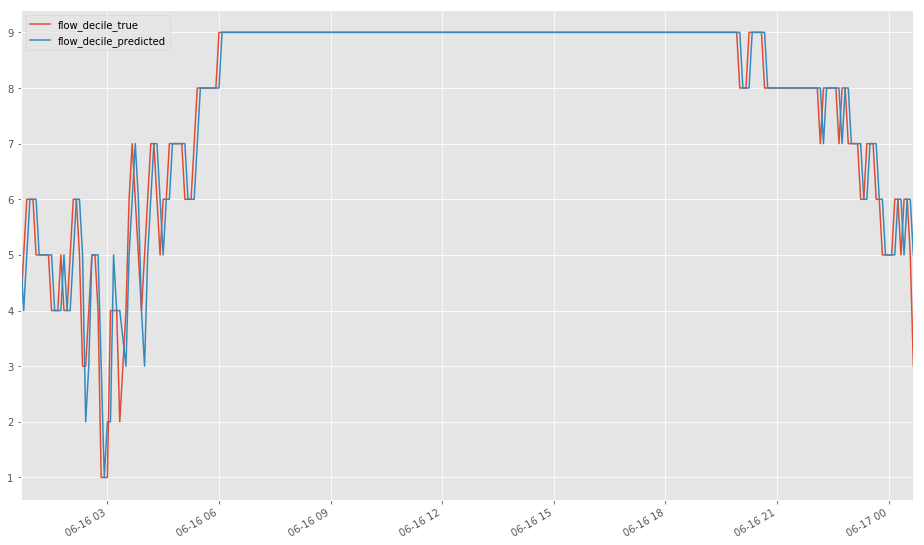

In [8]:
learner.load_best_model_from_disk()
learner.predict()

{'corr': 0.95696141572539839,
 'mae': 0.18335531838349922,
 'mape': inf,
 'mse': 0.22005036575128911,
 'msne': inf,
 'r2': 0.91490818787062356,
 'rae': 0.14913631378944295,
 'rmse': 0.46909526298108056,
 'rmsne': inf}

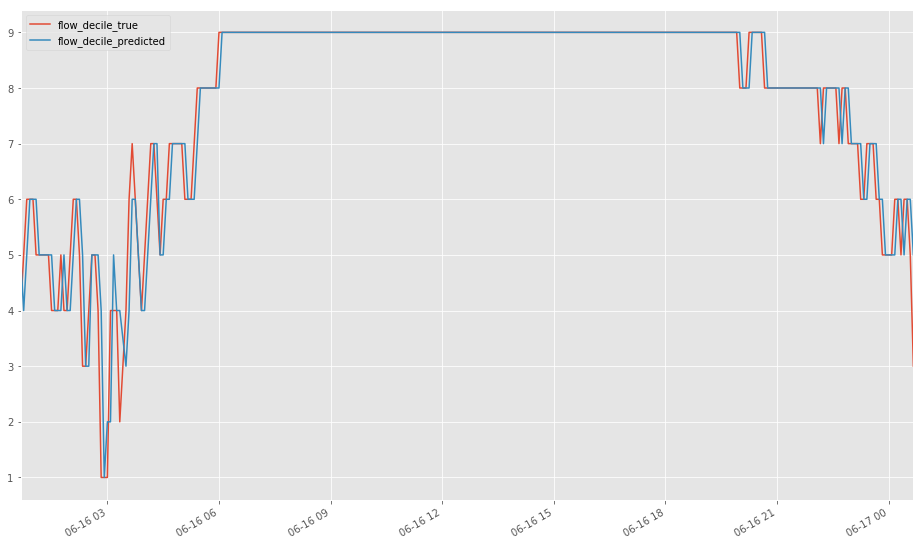

In [9]:
learner.baseline_lr()